<a href="https://colab.research.google.com/github/og-hayden/ai-ml/blob/main/Housing_Price_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available else "cpu"

In [284]:
df = pd.read_csv("/content/Housing.csv")

df.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


In [285]:
missing_values = df.isnull().sum()
missing_values

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [286]:
# Encode categorical values
data_encoded = pd.get_dummies(df, columns=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'], drop_first=True)
data_encoded.head(3)

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,1,0,0,0,1,1,0,0
1,12250000,8960,4,4,4,3,1,0,0,0,1,0,0,0
2,12250000,9960,3,2,2,2,1,0,1,0,0,1,1,0


In [287]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)
preprocessed_df = pd.DataFrame(scaled_data, index=data_encoded.index, columns=data_encoded.columns)
preprocessed_df.head(3)

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,4.566365,1.046726,1.403419,1.421812,1.378217,1.517692,0.405623,-0.465315,-0.734539,-0.219265,1.472618,1.804941,-0.844888,-0.696429
1,4.004484,1.757010,1.403419,5.405809,2.532024,2.679409,0.405623,-0.465315,-0.734539,-0.219265,1.472618,-0.554035,-0.844888,-0.696429
2,4.004484,2.218232,0.047278,1.421812,0.224410,1.517692,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.804941,1.183588,-0.696429


In [288]:
X = preprocessed_df.drop('price', axis=1)
y = preprocessed_df['price']

In [289]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(436, 13) (109, 13) (436,) (109,)


In [290]:
# Dataframe -> numpy array
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

# numpy array -> tensors
X_train, X_test = torch.tensor(X_train).to(device).type(torch.float32), torch.tensor(X_test).to(device).type(torch.float32)
y_train, y_test = torch.tensor(y_train).to(device).type(torch.float32), torch.tensor(y_test).to(device).type(torch.float32)

In [291]:
from torch.utils.data.dataloader import T
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [292]:
device

'cuda'

In [293]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=13, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=1)
  def forward(self, x):
    return self.layer_2(torch.relu(self.layer_1(x)))

In [294]:
model = Model().to(device)

In [295]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [296]:
epochs = 1000

training_history = {}
testing_history = {}

best_loss = float('inf') # initially setting best loss to infinity
patience = 20 # num epochs without improvement for early stop
no_improvement_epochs = 0

for epoch in range(epochs):
  # Training loop
  model.train()
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    preds = model(batch_X).squeeze()
    loss = loss_fn(preds, batch_y)
    loss.backward()
    optimizer.step()
  if (epoch + 1) % 100 == 0:
    print(f"Epoch: {epoch + 1} | Loss: {loss}")
  training_history[epoch] = loss.item() # appending history to list

  # Eval early stopping mechanism
  model.eval()
  with torch.inference_mode():
    test_preds = model(X_test).squeeze()
  test_loss = loss_fn(test_preds, y_test)
  testing_history[epoch] = test_loss.item()

  # Updating best parameters
  if test_loss < best_loss:
    best_loss = test_loss
    no_improvement_epochs = 0
    best_params = model.state_dict()
    best_params_epoch = epoch # saving which epochs weights were best
  else:
    no_improvement_epochs += 1

  # If early stopping is reached
  if no_improvement_epochs > patience:
    print(f"Early Stopping at {epoch + 1} epoch. Best parameters saved")
    model.load_state_dict(best_params)
    break

Early Stopping at 58 epoch. Best parameters saved


<function matplotlib.pyplot.show(close=None, block=None)>

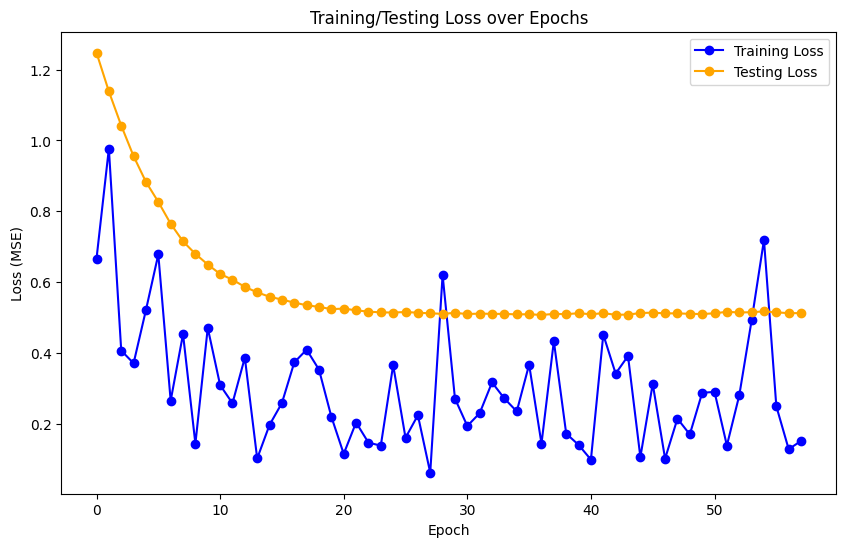

In [297]:
epochs = list(training_history.keys())
losses = list(training_history.values())

test_epochs = list(testing_history.keys())
test_losses = list(testing_history.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue', label="Training Loss")
plt.plot(test_epochs, test_losses, marker='o', linestyle='-', color='orange', label="Testing Loss")
plt.title("Training/Testing Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()

plt.show